In [1]:
import sys
import os
import torch 
import numpy as np
import architectures
import utils
import config
import dataloaders
import permutation_utils
import matplotlib.pyplot as plt
%matplotlib inline



## Choose Network and Training Modalities
An example of some simple choices is shown below, there are more options and choices available. 
To find them, check `config.py` or uncomment last line of cell below, and re-run.


In [2]:
parser = config.get_parser()
sys.argv = [
        '',
        '-net_type=mlp',
        '-n_hidden_layers=1',
        '-width=1000',
        '-dataset=cifar10'
    ]

args = parser.parse_args()

#parser.print_help()

Boring preprocessing in next cell

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=args.visible_gpu
np.random.seed(args.seed)
torch.manual_seed(args.seed)

def get_net_global():
    net =  architectures.get_new_net(   args.net_type, 
                                        arch, 
                                        args.device, 
                                        args.dataset, 
                                        bn=args.bn)
    return net
    
args = config.preprocess_args(args)
trainloader0, trainloader1, testloader = dataloaders.get_dataloaders(
                                                            args.dataset, 
                                                            args.net_type, 
                                                            args.batch_size, 
                                                            args.batch_size_2, 
                                                            num_workers=2)
if args.dataset != 'cifar10':
    input_dim = 784
else:
    input_dim = 3 * 32**2
output_dim = 10
if args.net_type == 'mlp':
    arch = [input_dim, *([args.width]*args.n_hidden_layers), output_dim]
if args.net_type == 'cnn':
    arch = args.cnn_arch
n_models = 2
criterion = torch.nn.CrossEntropyLoss()

net = get_net_global()
ws = permutation_utils.create_weight_dict(net)

print('Dataset:', args.dataset)
print('\nNetwork:\n', net)

Files already downloaded and verified
Files already downloaded and verified
Dataset: cifar10

Network:
 MySequential(
  (0): HookedLinear(in_features=3072, out_features=1000, bias=False)
  (1): ReLU()
  (2): HookedLinear(in_features=1000, out_features=10, bias=False)
)


# Train both networks 
(... and store weights from different points in time)

Tracking performance is not built into this simple demo, but can be easily done with code a few cells further below.

In [4]:
for model_id in range(2):
    print('\n\nStart Training Model', model_id)
    net = get_net_global()
    if not args.bn:
        optimized_parameters = net.parameters()
    else:
        # BN paramters are frozen, to zero mean unit variance
        optimized_parameters = permutation_utils.get_parameters_no_bn(net)
    if model_id == 0:
        opt = args.opt
        lr = args.lr
        trainloader = trainloader0
    if model_id == 1:
        opt = args.opt_2
        lr = args.lr_2
        trainloader = trainloader1
    if opt == 'AdamW':
        optimizer = torch.optim.AdamW(optimized_parameters, lr=lr)
    if opt == 'SGD':
        optimizer = torch.optim.SGD(optimized_parameters, lr=lr, momentum=args.sgd_mom, weight_decay=1e-4)
    print('optimizer', optimizer)
    param_update = 0 
    measured_updates = []
    while param_update < args.n_param_updates:
        for X,y in trainloader:
            if param_update >= args.n_param_updates:
                break
            if param_update % args.measure_period == 0 or param_update+1 == args.n_param_updates:
                permutation_utils.extend_weight_dict(ws, net, model_id, param_update)
                measured_updates.append(param_update)
                print('param update', param_update, 'of', args.n_param_updates)
            
            X, y = X.to(args.device), y.to(args.device)
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            param_update += 1



Start Training Model 0
optimizer AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)
param update 0 of 500
param update 499 of 500


Start Training Model 1
optimizer AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)
param update 0 of 500
param update 499 of 500


# Do the thing
The following two cells compute permutations and interpolate between permuted/unpermuted networks.

The main reason the second cell is "slow" is that it does lots of model evaluations (along the line interpolating between two different networks).

The second cell below will print some simple summary statistics, plotting functionality showing somewhat more information can be found further below.

The first cell below lets you choose at which point you want to compute the permutation and at which point you want to apply it.

In [5]:
compute_perm_at = measured_updates[-1]
apply_perm_at = measured_updates[-1]

print('Network weights were saved at the following updates:\n', measured_updates)
print('The permutation will be computed based on weights from update:', compute_perm_at)
print('and it will be applied to the weights from update:', apply_perm_at)

Network weights were saved at the following updates:
 [0, 499]
The permutation will be computed based on weights from update: 499
and it will be applied to the weights from update: 499


In [6]:
def get_interpolation_stats( 
        ws, 
        param_update, 
        perms=[None, None], 
        interpolation_points=np.linspace(0,1,11)):
    res_dict = {}
    for a in interpolation_points:
        neta = get_net_global()
        neta = permutation_utils.merge_networks(ws, 
                                                a=a, 
                                                param_updates=param_update, 
                                                net=neta, 
                                                perms=perms)
        if args.bn: 
            permutation_utils.recompute_bn_runnning_stats(neta, trainloader0, n_batches=100)
        res_dict[a] = utils.get_stats_dict(neta, trainloader0, testloader, device=args.device)
    return res_dict

# Activations of networks will be computed using 
# this many batches (of batch_size args.batch_size)
n_batches = 100

stored_results = {}

# Vanilla Interpolation
stored_results['vanilla'] = get_interpolation_stats(ws, apply_perm_at)
print('using parameters from update', apply_perm_at)
print('performance of vanilla averaged networks:\n', stored_results['vanilla'][0.5])

# Permuted Interpolation
# Initialise Individual Nets
net0 = get_net_global()
net1 = get_net_global()
net0 = permutation_utils.merge_networks(ws, a=1.0, param_updates=compute_perm_at, net=net0)
if args.bn: 
        permutation_utils.recompute_bn_runnning_stats(net0, trainloader0, n_batches=100)
net1 = permutation_utils.merge_networks(ws, a=0.0, param_updates=compute_perm_at, net=net1)
if args.bn: 
        permutation_utils.recompute_bn_runnning_stats(net1, trainloader0, n_batches=100)

# Get Activations, compute Permutation
activation_batches = 0
A0s, A1s = permutation_utils.get_activations(net0, net1, trainloader, 
                                            n_batches=n_batches, device=args.device)
costs = permutation_utils.compute_cost_matrices(A0s, A1s)
ps = permutation_utils.compute_permutations(costs)

# Permuted Interpolation
stored_results['perm'] = get_interpolation_stats(ws, apply_perm_at, perms=[None, ps])
print('\n\npermutation computed at update:', compute_perm_at, 
'\nand applied at update', apply_perm_at, )
print('performance of permuted, averaged networks:\n', stored_results['perm'][0.5])

using parameters from update 499
performance of vanilla averaged networks:
 {'train_acc': 0.43, 'test_acc': 0.407, 'train_nll': 1.746586561203003, 'train_nll_T': 1.7327826023101807, 'train_temp': 1.232846739442066, 'test_temp': 1.1497569953977356, 'test_nll': 1.800485372543335, 'test_nll_T': 1.796633005142212}


permutation computed at update: 499 
and applied at update 499
performance of permuted, averaged networks:
 {'train_acc': 0.4749, 'test_acc': 0.4456, 'train_nll': 1.560697317123413, 'train_nll_T': 1.533729910850525, 'train_temp': 0.7564633275546289, 'test_temp': 0.7054802310718644, 'test_nll': 1.6608035564422607, 'test_nll_T': 1.6099597215652466}


# Now for some plotting
Choose which quantity you want to plot in first line of cell below.

Check output of cell above for which quantities are available (keys of printed dict are what's available).

permutation computed at update: 499 
and applied at update 499


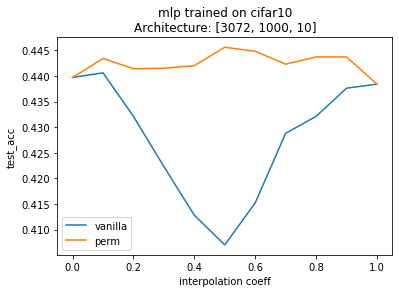

In [10]:
quantity = 'test_acc' 

fig, ax = plt.subplots()
variant = 'vanilla'
for variant in ['vanilla', 'perm']:
    x_axis = list(stored_results[variant].keys())
    y_vals = []
    for x in x_axis:
        y_vals.append( stored_results[variant][x][quantity] )
    ax.plot(x_axis, y_vals, label=variant)
ax.legend()
ax.set_ylabel(quantity)
ax.set_xlabel('interpolation coeff')

ax.set_title(args.net_type + ' trained on ' + args.dataset + '\nArchitecture: ' + str(arch))
print('permutation computed at update:', compute_perm_at, 
'\nand applied at update', apply_perm_at, )
